# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [5]:
# import libraries

import pandas as pd
import numpy as np
import re
import pickle

import matplotlib.pyplot as plt

from sqlalchemy import create_engine

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, make_scorer, accuracy_score, f1_score, fbeta_score

from sklearn.model_selection import GridSearchCV

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterResponsePipeline.db')
df = pd.read_sql_table('messages', engine)


In [3]:
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.describe()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26216.00000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,...,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,15224.82133,0.773650,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,...,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584
std,8826.88914,0.435276,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,...,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114
min,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7446.75000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15662.50000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22924.25000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30265.00000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
cat_names = df.iloc[:,5:].columns
cat_count = (df.iloc[:,5:]).sum()
cat_count = cat_count.sort_values(ascending = False)
cat = list(cat_count.index)

#cat_df = pd.DataFrame(list(zip(cat_names, cat_count)), 
#               columns =['cat_name', 'cat_count']) 
#cat_df = cat_df.sort_values(by='cat_count', ascending=False)
#cat_df = cat_df.reset_index(drop=True)

In [60]:
#cat_df
cat
cat_count

aid_related               10860
weather_related            7297
direct_report              5075
request                    4474
other_aid                  3446
food                       2923
earthquake                 2455
storm                      2443
shelter                    2314
floods                     2155
medical_help               2084
infrastructure_related     1705
water                      1672
other_weather              1376
buildings                  1333
medical_products           1313
transport                  1201
death                      1194
other_infrastructure       1151
refugees                    875
military                    860
search_and_rescue           724
money                       604
electricity                 532
cold                        530
security                    471
clothing                    405
aid_centers                 309
missing_people              298
hospitals                   283
fire                        282
tools   

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34],
 <a list of 35 Text xticklabel objects>)

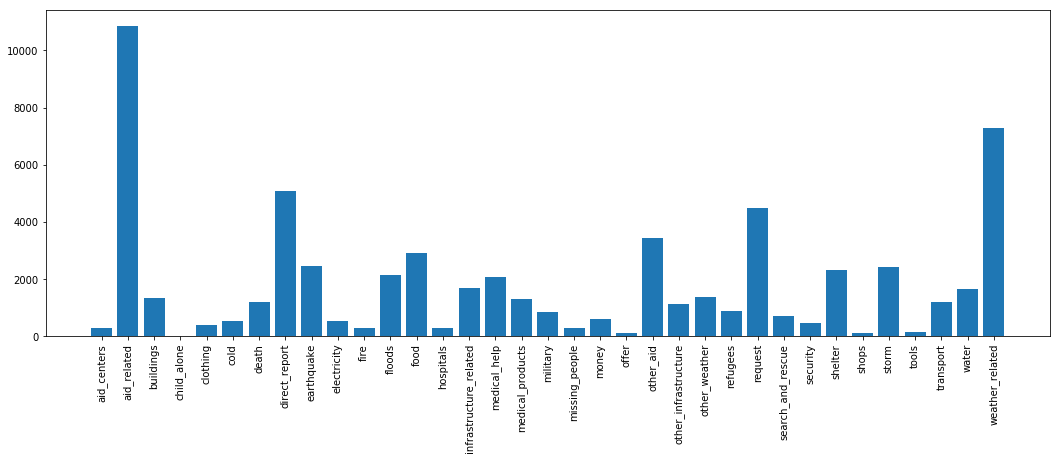

In [63]:
fig = plt.figure(figsize=(18, 6))
#plt.bar(cat_df['cat_name'], cat_df['cat_count'])
plt.bar(cat, cat_count)
plt.xticks(rotation=90)

In [5]:
#Remove child alone because 0 only
df = df.drop(['child_alone'],axis=1)

In [6]:
#df = df[df.related != 2]
df['related']=df['related'].map(lambda x: 1 if x == 2 else x)

In [7]:
X = df['message']
y = df.iloc[:,4:]

In [58]:
# wrapping previous steps in the load_data method
def load_data(database_filepath = 'DisasterResponsePipeline.db'):
    engine = create_engine('sqlite:///'+database_filepath)
    df = pd.read_sql_table('messages', engine)
    
    df = df.drop(['child_alone'],axis=1)
    
    X = df['message']
    y = df.iloc[:,4:]
    
    return X, y

### 2. Write a tokenization function to process your text data

In [8]:
def tokenize(text):
    
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    stop_words = stopwords.words("english")
    
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # Extract and replace all urls from text 
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

        
    clean_tokens= [lemmatizer.lemmatize(word).lower().strip() for word in tokens]
    
    return clean_tokens

    

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [10]:
pipeline_1 = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ]))      
    ])),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
model =[]
model = pipeline_1
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_d...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [13]:
y_pred = model.predict(X_test)

In [15]:
# multi f-1 score

# macro , weighted, samples
f1_micro, f1_macro, f1_weighted, f1_samples = f1_score(y_test, y_pred, average='micro'), f1_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred)), f1_score(y_test, y_pred, average='samples', labels=np.unique(y_pred))


print('F1 score (micro) {0:.2f}%\n'.format(f1_micro*100))
print('F1 score (macro) {0:.2f}%\n'.format(f1_macro*100))
print('F1 score (weighted) {0:.2f}%\n'.format(f1_weighted*100))
print('F1 score (samples) {0:.2f}%\n'.format(f1_samples*100))


F1 score (micro) 56.62%

F1 score (macro) 20.51%

F1 score (weighted) 49.22%

F1 score (samples) 47.15%



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [16]:
df_y_pred = pd.DataFrame(y_pred, columns = y_test.columns)

for column in df_y_pred.columns:
    print('\n')
    print('Column: {}\n'.format(column))
    print(classification_report(y_test[column], df_y_pred[column]))



Column: related

             precision    recall  f1-score   support

          0       0.59      0.33      0.42      1525
          1       0.82      0.93      0.87      5029

avg / total       0.77      0.79      0.77      6554



Column: request

             precision    recall  f1-score   support

          0       0.88      0.99      0.93      5416
          1       0.84      0.35      0.50      1138

avg / total       0.87      0.88      0.85      6554



Column: offer

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6531
          1       0.00      0.00      0.00        23

avg / total       0.99      1.00      0.99      6554



Column: aid_related

             precision    recall  f1-score   support

          0       0.72      0.88      0.79      3816
          1       0.76      0.52      0.62      2738

avg / total       0.74      0.73      0.72      6554



Column: medical_help

             precision    recall  f1-s

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 6. Improve your model
Use grid search to find better parameters. 

In [25]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'features', 'clf', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__text_pipeline', 'features__text_pipeline__memory', 'features__text_pipeline__steps', 'features__text_pipeline__vect', 'features__text_pipeline__tfidf', 'features__text_pipeline__vect__analyzer', 'features__text_pipeline__vect__binary', 'features__text_pipeline__vect__decode_error', 'features__text_pipeline__vect__dtype', 'features__text_pipeline__vect__encoding', 'features__text_pipeline__vect__input', 'features__text_pipeline__vect__lowercase', 'features__text_pipeline__vect__max_df', 'features__text_pipeline__vect__max_features', 'features__text_pipeline__vect__min_df', 'features__text_pipeline__vect__ngram_range', 'features__text_pipeline__vect__preprocessor', 'features__text_pipeline__vect__stop_words', 'features__text_pipeline__vect__strip_accents', 'features__text_pipeline__vect__token_pattern', 'features__text_pipeline__vect__tokenizer', 

In [66]:
parameters = {
    'clf__estimator__n_estimators': [50, 100, 200],
    'clf__estimator__min_samples_split': [2, 3, 4],
}

cv = GridSearchCV(model, param_grid=parameters, scoring='f1', verbose = 2, n_jobs = -1)
cv.fit(X_train, y_train)    
    

In [67]:
cv_prediciton_test = cv.predict(X_test)

In [ ]:
#new

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [56]:
print(classification_report(y_test, cv_prediciton_test, target_names=y.columns.values))

                        precision    recall  f1-score   support

               related       0.83      0.95      0.89      4993
               request       0.80      0.57      0.66      1141
                 offer       0.11      0.03      0.05        34
           aid_related       0.77      0.59      0.67      2707
          medical_help       0.64      0.29      0.40       503
      medical_products       0.66      0.32      0.43       314
     search_and_rescue       0.62      0.13      0.21       182
              security       0.23      0.04      0.07       113
              military       0.62      0.29      0.39       227
                 water       0.76      0.63      0.69       456
                  food       0.82      0.65      0.73       756
               shelter       0.77      0.56      0.65       599
              clothing       0.59      0.36      0.45       103
                 money       0.55      0.29      0.38       143
        missing_people       0.85      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# multi f-1 score

# macro , weighted, samples
f1_micro_cv = f1_score(y_test, cv_prediciton_test, average='micro')
f1_macro_cv = f1_score(y_test, cv_prediciton_test, average='macro')
f1_weighted_cv = f1_score(y_test, cv_prediciton_test, average='weighted', labels=np.unique(y_pred_test))
f1_samples_cv = f1_score(y_test, cv_prediciton_test, average='samples', labels=np.unique(y_pred_test))


print('Old: F1 score (micro) {0:.2f}%\n'.format(f1_micro*100))
print('CV: F1 score (micro) {0:.2f}%\n'.format(f1_micro_cv*100))
print('Old: F1 score (macro) {0:.2f}%\n'.format(f1_macro*100))
print('CV: F1 score (macro) {0:.2f}%\n'.format(f1_macro_cv*100))
print('Old: F1 score (weighted) {0:.2f}%\n'.format(f1_weighted*100))
print('CV: F1 score (weighted) {0:.2f}%\n'.format(f1_weighted_cv*100))
print('Old: F1 score (samples) {0:.2f}%\n'.format(f1_samples*100))
print('CV: F1 score (samples) {0:.2f}%\n'.format(f1_samples_cv*100))

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [10]:
# additional feature Starting Verb

class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)


In [11]:
# try Ada Boost
pipeline_2 = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),
        ('starting_verb', StartingVerbExtractor())        
    ])),
    ('clf', MultiOutputClassifier(AdaBoostClassifier()))
])



In [12]:
model =[]
model = pipeline_2
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('vect',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
                                                                                  input='content',
                                                                                  low

In [13]:
#y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

In [14]:
#Accuracy
accuracy = ((y_pred == y_test).mean()).mean()
print("Accuracy:", accuracy)

Accuracy: 0.9472165307990758


In [15]:
# multi f-1 score

# macro , weighted, samples
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
f1_samples = f1_score(y_test, y_pred, average='samples', labels=np.unique(y_pred))


print('F1 score (micro) {0:.2f}%\n'.format(f1_micro*100))
print('F1 score (macro) {0:.2f}%\n'.format(f1_macro*100))
print('F1 score (weighted) {0:.2f}%\n'.format(f1_weighted*100))
print('F1 score (samples) {0:.2f}%\n'.format(f1_samples*100))

F1 score (micro) 66.64%

F1 score (macro) 41.70%

F1 score (weighted) 83.72%

F1 score (samples) 69.06%



C:\Users\marku\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\marku\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [16]:
df_y_pred = pd.DataFrame(y_pred, columns = y_test.columns)

In [17]:
for column in df_y_pred.columns:
    print('\n')
    print('Column: {}\n'.format(column))
    print(classification_report(y_test[column], df_y_pred[column]))



Column: related

              precision    recall  f1-score   support

           0       0.67      0.35      0.46      1563
           1       0.82      0.95      0.88      4991

    accuracy                           0.80      6554
   macro avg       0.75      0.65      0.67      6554
weighted avg       0.79      0.80      0.78      6554



Column: request

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5438
           1       0.79      0.55      0.65      1116

    accuracy                           0.90      6554
   macro avg       0.85      0.76      0.79      6554
weighted avg       0.89      0.90      0.89      6554



Column: offer

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6514
           1       0.29      0.05      0.09        40

    accuracy                           0.99      6554
   macro avg       0.64      0.52      0.54      6554
weighted avg       

In [23]:
model

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_d...mator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
           n_jobs=1))])

In [38]:
model.get_params().keys() 


dict_keys(['memory', 'steps', 'features', 'clf', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__text_pipeline', 'features__starting_verb', 'features__text_pipeline__memory', 'features__text_pipeline__steps', 'features__text_pipeline__vect', 'features__text_pipeline__tfidf', 'features__text_pipeline__vect__analyzer', 'features__text_pipeline__vect__binary', 'features__text_pipeline__vect__decode_error', 'features__text_pipeline__vect__dtype', 'features__text_pipeline__vect__encoding', 'features__text_pipeline__vect__input', 'features__text_pipeline__vect__lowercase', 'features__text_pipeline__vect__max_df', 'features__text_pipeline__vect__max_features', 'features__text_pipeline__vect__min_df', 'features__text_pipeline__vect__ngram_range', 'features__text_pipeline__vect__preprocessor', 'features__text_pipeline__vect__stop_words', 'features__text_pipeline__vect__strip_accents', 'features__text_pipeline__vect__token_pattern', 'features__text_p

In [18]:
parameters = {
        'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
        'features__text_pipeline__vect__max_df': (0.5, 0.75, 1.0),
        'features__text_pipeline__vect__max_features': (None, 5000, 10000),
        'features__text_pipeline__tfidf__use_idf': (True, False),
#        'clf__estimator__n_estimators': [50, 100, 200],
#        'features__transformer_weights': (
#            {'text_pipeline': 1, 'starting_verb': 0.5},
#            {'text_pipeline': 0.5, 'starting_verb': 1},
#            {'text_pipeline': 0.8, 'starting_verb': 1},
#        )
     }

cv = GridSearchCV(model, param_grid=parameters, scoring='f1_macro', verbose = 2, n_jobs = -1)
cv.fit(X_train, y_train)    
    

C:\Users\marku\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 55.3min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 171.4min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('text_pipeline',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('vect',
                                                                                         CountVectorizer(analyzer='word',
                                                                                                         binary=False,
                                                                                                         decode_error='strict',
                                                                                                         dtype=<class 'numpy.int64'

In [19]:
cv_pred =cv.predict(X_test)

In [21]:
#Accuracy
accuracy = ((cv_pred == y_test).mean()).mean()
print("Accuracy:", accuracy)

Accuracy: 0.9469070142551986


In [22]:
# multi f-1 score

# macro , weighted, samples
f1_micro_cv = f1_score(y_test, cv_pred, average='micro')
f1_macro_cv = f1_score(y_test, cv_pred, average='macro')
f1_weighted_cv = f1_score(y_test, cv_pred, average='weighted', labels=np.unique(y_pred))
f1_samples_cv = f1_score(y_test, cv_pred, average='samples', labels=np.unique(y_pred))


print('F1 score (micro) {0:.2f}%\n'.format(f1_micro_cv*100))
print('F1 score (macro) {0:.2f}%\n'.format(f1_macro_cv*100))
print('F1 score (weighted) {0:.2f}%\n'.format(f1_weighted_cv*100))
print('F1 score (samples) {0:.2f}%\n'.format(f1_samples_cv*100))

F1 score (micro) 66.62%

F1 score (macro) 41.73%

F1 score (weighted) 83.55%

F1 score (samples) 67.89%



C:\Users\marku\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\marku\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [26]:
df_y_pred_cv = pd.DataFrame(cv_pred, columns = y_test.columns)

In [27]:
for column in df_y_pred.columns:
    print('\n')
    print('Column: {}\n'.format(column))
    print(classification_report(y_test[column], df_y_pred_cv[column]))



Column: related

              precision    recall  f1-score   support

           0       0.63      0.38      0.48      1563
           1       0.83      0.93      0.88      4991

    accuracy                           0.80      6554
   macro avg       0.73      0.66      0.68      6554
weighted avg       0.78      0.80      0.78      6554



Column: request

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      5438
           1       0.77      0.57      0.66      1116

    accuracy                           0.90      6554
   macro avg       0.84      0.77      0.80      6554
weighted avg       0.89      0.90      0.89      6554



Column: offer

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6514
           1       0.00      0.00      0.00        40

    accuracy                           0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       

### 9. Export your model as a pickle file

In [25]:
#
final_model = cv
pickle.dump(final_model, open('model_cv.pkl', 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.